# 梯度和自动微分简介

## 自动微分和梯度

[自动微分](https://en.wikipedia.org/wiki/Automatic_differentiation)对于实现机器学习算法（例如，用于训练神经网络的[反向传播](https://en.wikipedia.org/wiki/Backpropagation)）非常有用。

在本指南中，您将探索使用 TensorFlow 计算梯度的方法，尤其是在 [Eager Execution](eager.ipynb) 中。

## 设置

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## 计算梯度

要实现自动微分，TensorFlow 需要记住在*前向传递*过程中哪些运算以何种顺序发生。随后，在*后向传递*期间，TensorFlow 以相反的顺序遍历此运算列表来计算梯度。

## 梯度带

TensorFlow 为自动微分提供了 [`tf.GradientTape`](https://tensorflow.google.cn/api_docs/python/tf/GradientTape) API；即计算某个计算相对于某些输入（通常是 [`tf.Variable`](https://tensorflow.google.cn/api_docs/python/tf/Variable)）的梯度。TensorFlow 会将在 [`tf.GradientTape`](https://tensorflow.google.cn/api_docs/python/tf/GradientTape) 上下文内执行的相关运算“记录”到“磁带”上。然后，TensorFlow 使用该磁带来计算“记录”计算的梯度。该“记录”使用了[反向模式微分](https://en.wikipedia.org/wiki/Automatic_differentiation)。
> 太绕了，可能翻译不准确，原文:
>
> TensorFlow provides the tf.GradientTape API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually tf.Variables. TensorFlow "records" relevant operations executed inside the context of a tf.GradientTape onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

例如：

In [3]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  # x^2, x 的 2 次幂
  y = x**2

记录一些运算后，使用 [`GradientTape.gradient(target, sources)`](https://tensorflow.google.cn/api_docs/python/tf/GradientTape#gradient) 计算某个目标（通常是损失）相对于某个源（通常是模型变量）的梯度。

In [4]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

上方示例使用标量，但是 [`tf.GradientTape`](https://tensorflow.google.cn/api_docs/python/tf/GradientTape) 在任何张量上都可以轻松运行：

In [8]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
print(w)
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
print(b)
x = [[1., 2., 3.]]
print(x)

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

<tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.0263447 , -1.9294524 ],
       [ 0.33462816,  0.7714855 ],
       [ 0.21025865, -1.5949938 ]], dtype=float32)>
<tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>
[[1.0, 2.0, 3.0]]


要获得 `loss` 相对于两个变量的梯度，可以将这两个变量同时作为 `gradient` 方法的源传递。梯度带在关于源的传递方式上非常灵活，可以接受列表或字典的任何嵌套组合，并以相同的方式返回梯度结构（请参阅 [`tf.nest`](https://tensorflow.google.cn/api_docs/python/tf/nest)）。

In [7]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

相对于每个源的梯度具有源的形状：

In [8]:
print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


此处也为梯度计算，这一次传递了一个变量字典：

In [9]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-3.6300485 , -0.20449638], dtype=float32)>

## 相对于模型的梯度

通常将 `tf.Variables` 收集到 [`tf.Module`](https://tensorflow.google.cn/api_docs/python/tf/Module) 或其子类之一（[`layers.Layer`](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Layer)、[`keras.Model`](https://tensorflow.google.cn/api_docs/python/tf/keras/Model)）中，用于[设置检查点](checkpoint.ipynb)和[导出](saved_model.ipynb)。

在大多数情况下，需要计算相对于模型的可训练变量的梯度。 由于 `tf.Module` 的所有子类都在 [`Module.trainable_variables`](https://tensorflow.google.cn/api_docs/python/tf/Module#trainable_variables) 属性中聚合其变量，您可以用几行代码计算这些梯度： 

In [10]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # 前向传递(Forward pass)
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# 计算每个可训练变量的梯度
grad = tape.gradient(loss, layer.trainable_variables)

In [11]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


<a id="watches"></a>

## 控制梯度带监视的内容

默认行为是在访问可训练 `tf.Variable` 后记录所有运算。原因如下：

- 梯度带需要知道在前向传递中记录哪些运算，以计算 后向传递 中的梯度。
- 梯度带包含对中间输出的引用，因此应避免记录不必要的操作。
- 最常见用例涉及计算损失相对于模型的所有可训练变量的梯度。

以下示例无法计算梯度，因为默认情况下 [`tf.Tensor`](https://tensorflow.google.cn/api_docs/python/tf/Tensor) 未被“监视”，并且 `tf.Variable` 不可训练：

In [12]:
# 可训练变量
x0 = tf.Variable(3.0, name='x0')
# 不可训练
x1 = tf.Variable(3.0, name='x1', trainable=False)
# 不是变量：变量+张量返回一个张量。
x2 = tf.Variable(2.0, name='x2') + 1.0
# 不是变量
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


您可以使用 `GradientTape.watched_variables` 方法列出梯度带正在监视的变量：

In [11]:
[var.name for var in tape.watched_variables()]

['x0:0']

`tf.GradientTape` 提供了钩子，让用户可以控制被监视或不被监视的内容。

要记录相对于 `tf.Tensor` 的梯度，您需要调用 `GradientTape.watch(x)`：

In [12]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


相反，要停用监视所有 `tf.Variables` 的默认行为，请在创建梯度带时设置 `watch_accessed_variables=False`。此计算使用两个变量，但仅连接其中一个变量的梯度：

In [13]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

由于 `GradientTape.watch` 未在 `x0` 上调用，未相对于它计算梯度：

In [14]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


## 中间结果

您还可以请求输出相对于 `tf.GradientTape` 上下文中计算的中间值的梯度。

In [15]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


默认情况下，只要调用 `GradientTape.gradient` 方法，就会释放 `GradientTape` 保存的资源。要在同一计算中计算多个梯度，请创建一个 `persistent=True` 的梯度带。这样一来，当梯度带对象作为垃圾回收时，随着资源的释放，可以对 `gradient` 方法进行多次调用。例如：

In [16]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # 108.0 (4 * x**3 at x = 3)
print(tape.gradient(y, x).numpy())  # 6.0 (2 * x)

[  4. 108.]
[2. 6.]


In [17]:
del tape   # Drop the reference to the tape

## 性能说明

- 在梯度带上下文内进行运算会有一个微小的开销。对于大多数 Eager Execution 来说，这一成本并不明显，但是您仍然应当仅在需要的地方使用梯度带上下文。

- 梯度带使用内存来存储中间结果，包括输入和输出，以便在后向传递中使用。

    为了提高效率，某些运算（例如 `ReLU`）不需要保留中间结果，而是在前向传递中进行剪枝。不过，如果在梯度带上使用 `persistent=True`，则*不会丢弃任何内容*，并且峰值内存使用量会更高。

## 非标量目标的梯度

梯度从根本上说是对标量的运算。

In [18]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


因此，如果需要多个目标的梯度，则每个源的结果为：

- 目标总和的梯度，或等效
- 每个目标的梯度总和。

In [19]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


类似地，如果目标不是标量，则计算总和的梯度：

In [20]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


这样一来，就可以轻松获取损失集合总和的梯度，或者逐元素损失计算总和的梯度。

如果每个条目都需要单独的梯度，请参阅[雅可比矩阵](advanced_autodiff.ipynb#jacobians)。

在某些情况下，您可以跳过雅可比矩阵。对于逐元素计算，总和的梯度给出了每个元素相对于其输入元素的导数，因为每个元素都是独立的：

In [21]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

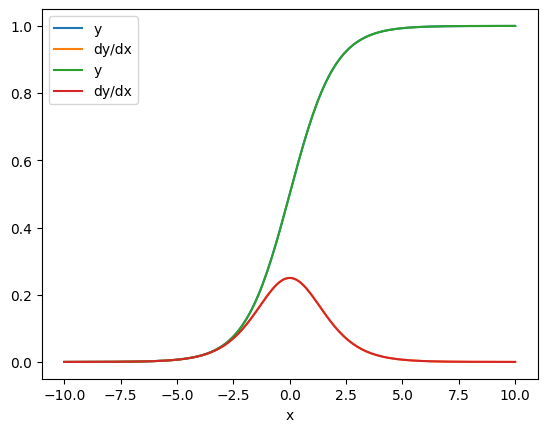

In [23]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')
plt.show()

## 控制流

在执行运算时，由于梯度带会记录这些运算，因此会自然地处理 Python 控制流（例如 `if` 和 `while` 语句）。

此处，`if` 的每个分支上使用不同变量。梯度仅连接到使用的变量：

In [24]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


注意，控制语句本身不可微分，因此对基于梯度的优化器不可见。

根据上面示例中 `x` 的值，梯度带将记录 `result = v0` 或 `result = v1**2`。 相对于 `x` 的梯度始终为 `None`。

In [25]:
dx = tape.gradient(result, x)

print(dx)

None


## 获取 `None` 的梯度

当目标未连接到源时，您将获得 `None` 的梯度。


In [26]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


此处 `z` 显然未连接到 `x`，但可以通过几种不太明显的方式将梯度断开。

### 1. 使用张量替换变量

在[控制梯度带监视内容](#watches)部分中，梯度带会自动监视 `tf.Variable`，但不会监视 `tf.Tensor`。

一个常见错误是无意中将 `tf.Variable` 替换为 `tf.Tensor`，而不使用 `Variable.assign` 更新 `tf.Variable`。见下例：

In [27]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1

  print(type(x).__name__, ":", tape.gradient(y, x))
  x = x + 1   # This should be `x.assign_add(1)`

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


### 2.在 TensorFlow 之外进行了计算

如果计算退出 TensorFlow，梯度带将无法记录梯度路径。例如：

In [28]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


### 3.通过整数或字符串获取梯度

整数和字符串不可微分。如果计算路径使用这些数据类型，则不会出现梯度。

谁也不会期望字符串是可微分的，但是如果不指定 `dtype`，很容易意外创建一个 `int` 常量或变量。

In [29]:
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


TensorFlow 不会在类型之间自动进行转换，因此，在实践中，您经常会遇到类型错误而不是缺少梯度。

### 4. 通过有状态对象获取梯度

状态会停止梯度。从有状态对象读取时，梯度带只能观察当前状态，而不能观察导致该状态的历史记录。

`tf.Tensor` 不可变。张量创建后就不能更改。它有一个*值*，但没有*状态*。目前讨论的所有运算也都无状态：`tf.matmul` 的输出只取决于它的输入。

`tf.Variable` 具有内部状态，即它的值。使用变量时，会读取状态。计算相对于变量的梯度是正常操作，但是变量的状态会阻止梯度计算进一步向后移动。 例如：


In [30]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  x1.assign_add(x0)
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

None


类似地，`tf.data.Dataset` 迭代器和 `tf.queue` 也有状态，会停止经过它们的张量上的所有梯度。

## 未注册梯度

某些 `tf.Operation` 被**注册为不可微分**，将返回 `None`。还有一些则**未注册梯度**。

`tf.raw_ops` 页面显示了哪些低级运算已经注册梯度。

如果您试图通过一个没有注册梯度的浮点运算获取梯度，梯度带将抛出错误，而不是直接返回 `None`。这样一来，您可以了解某个环节出现问题。

例如，`tf.image.adjust_contrast` 函数封装了 `raw_ops.AdjustContrastv2`，此运算可能具有梯度，但未实现该梯度：


In [31]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')


LookupError: gradient registry has no entry for: AdjustContrastv2


如果需要通过此运算进行微分，则需要实现梯度并注册该梯度（使用 `tf.RegisterGradient`），或者使用其他运算重新实现该函数。

## 零而不是 None

在某些情况下，对于未连接的梯度，得到 0 而不是 `None` 会比较方便。您可以使用 `unconnected_gradients` 参数来决定具有未连接的梯度时返回的内容：

In [32]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
